In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geoplot as gplt
import geopandas as gpd

%matplotlib inline

/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


2/24/17

In this notebook I test doing some basic rollups of demographic data from ACS census tables (2010-2015 averages) by fire management area. In addition, I attempt to explore the capabilities of the geopandas and geoplot libraries for easy python-based static spatial mapping within a notebook.

**NOTE: geopandas currently requires a python 3.5 environment and is not available for windows**


One way to do this is in conda:

`$ conda create -n py35 python=3.5 geoplot`
    




In [2]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [3]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, executes query in psql, and pulls results into pandas df
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [5]:
from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe!")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [6]:
# get all rows from census block to fma lookup table 
QUERY1='''SELECT *
FROM fmac_proportion;
'''

In [7]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT *
FROM fmac_proportion;



In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 4 columns):
c_block        770 non-null object
fma            770 non-null object
overlap_cbg    770 non-null float64
overlap_fma    770 non-null float64
dtypes: float64(2), object(2)
memory usage: 24.1+ KB


In [9]:
df1.head(10)

,c_block,fma,overlap_cbg,overlap_fma
0,410050201001,10,0.002468,7.874073e-04
1,410050203032,10,0.000015,7.926580e-07
2,410050203041,18,0.000056,4.442453e-06
3,410050208001,10,0.001001,2.550445e-04
4,410050208001,20,0.055454,1.285901e-02
5,410050209001,20,0.239613,8.783360e-03
6,410050210001,25,0.003061,1.808271e-04
7,410050210002,20,0.006363,6.558618e-04
8,410050210002,25,0.015021,1.445884e-03
9,410050212001,20,0.042128,4.428812e-03


Each row in this lookup table is an intersection of census block group (c_block) to Fire Management Area (fma). 

* overlap_cbg is the proprtion calculated by intersection area / total census block area

* overlap_fma is the proportion calculated by intersection area / total fma area



**Now I test some queries converting data by census block group to fma**

In [10]:
# try joining census total population by census block group to fma
# include fma geometry in query
QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

In [11]:
df2 = gpd_query(QUERY2) # note the use of gdp_query() since we want tot return a geopandas dataframe

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC


created geopandas dataframe!


In [12]:
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
fma                     31 non-null object
fma_population_total    31 non-null int64
geom                    31 non-null object
dtypes: int64(1), object(2)
memory usage: 824.0+ bytes


In [13]:
df2

,fma,fma_population_total,geom
0,07,42544,"(POLYGON ((-122.53768848 45.49444708800007, -1..."
1,25,41133,(POLYGON ((-122.5996791489999 45.4614523220000...
2,14,37634,(POLYGON ((-122.6452597909999 45.5482393280000...
3,09,34321,"(POLYGON ((-122.618542734 45.49893638500004, -..."
4,11,34236,(POLYGON ((-122.5648676069999 45.4598086640000...
5,31,31487,"(POLYGON ((-122.487770149 45.48629978200006, -..."
6,19,30588,"(POLYGON ((-122.581914988 45.50345943100007, -..."
7,28,28355,"(POLYGON ((-122.628283273 45.52984537400005, -..."
8,18,27347,"(POLYGON ((-122.733431708 45.43437200000005, -..."
9,29,24628,"(POLYGON ((-122.532502628 45.46131735600005, -..."


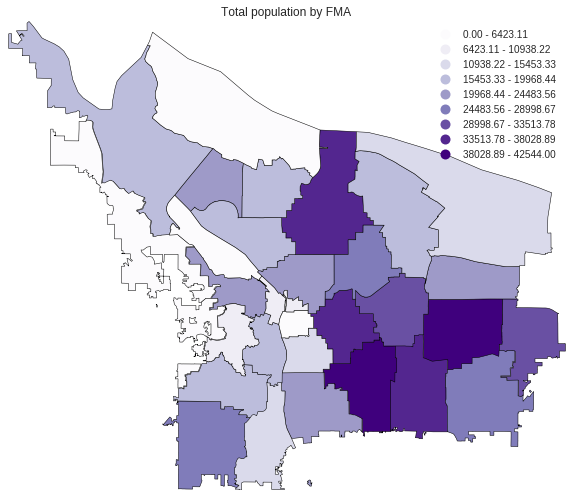

In [14]:
# map of population by fma
import geoplot.crs as gcrs # allow different projections

gplt.choropleth(df2,
                hue=df2['fma_population_total'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total population by FMA")

In [15]:
# try joining census housing_tenure by census block group to fma
QUERY3='''SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC
'''

In [16]:
df3 = gpd_query(QUERY3)  

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC


created geopandas dataframe!


In [17]:
df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
fma                        31 non-null object
total_households           31 non-null int64
total_owner_occupied       31 non-null int64
percent_owner_occupied     31 non-null float64
total_renter_occupied      31 non-null int64
percent_renter_occupied    31 non-null float64
geom                       31 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 1.8+ KB


In [54]:
df3[df3.columns[:5]] # not printing out geom column

,fma,total_households,total_owner_occupied,percent_owner_occupied,total_renter_occupied
0,25,17263,9648,0.558886,7615
1,09,15456,8071,0.522185,7385
2,07,14879,6141,0.412705,8738
3,14,14326,9551,0.666703,4775
4,03,14052,3640,0.259041,10412
5,19,12574,6989,0.555833,5585
6,11,12245,6399,0.522552,5847
7,28,11831,7678,0.648990,4153
8,18,11570,7581,0.655211,3989
9,13,11457,4717,0.411670,6741


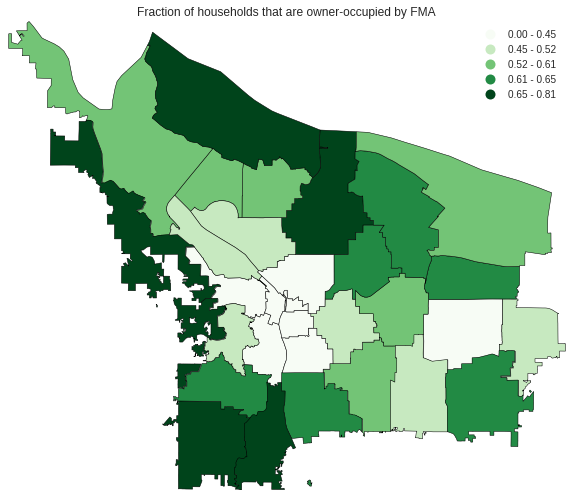

In [19]:
gplt.choropleth(df3,
                hue=df3['percent_owner_occupied'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Greens',
                linewidth=0.5,
                #k=9,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that are owner-occupied by FMA")

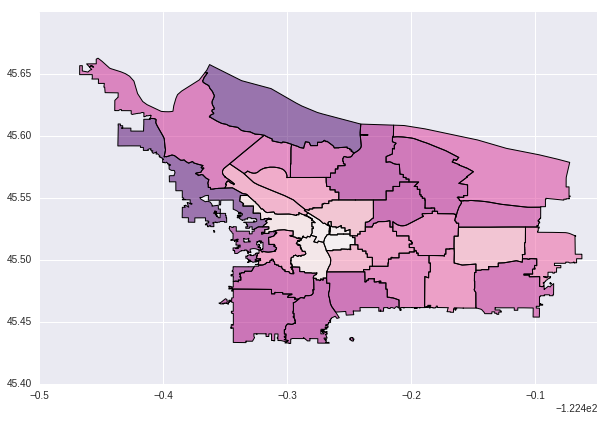

In [20]:
# choropleth map of FMA by percent owner occupied using matplotlib
# NOTE: I had to remove the legend to prevent matplotlib from throwing an error from scaling based on a float number

df3.plot(column='percent_owner_occupied', cmap= 'RdPu',figsize=(10,10))

In [21]:
# try joining census estimate_median_household_income by census block group to fma
# note this is not a statistically valid query since we can't simply apply a weighted average to medians
# but it's at least one approach to approximate a median for fmas

QUERY4='''SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC
'''

In [22]:
df4 = gpd_query(QUERY4)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC


created geopandas dataframe!


In [23]:
#df4.info()

In [59]:
df4[df4.columns[:2]]

,fma,median_household_income
0,27,137883.0
1,16,130537.0
2,15,117597.0
3,10,108234.0
4,05,90861.0
5,03,90696.0
6,06,84673.0
7,18,81527.0
8,22,72752.0
9,09,71971.0


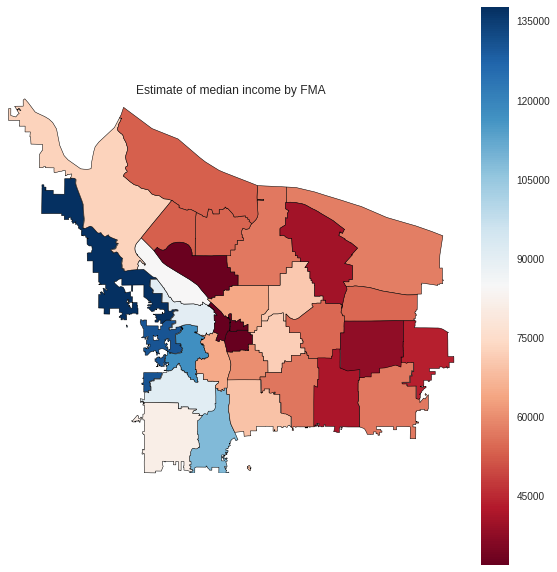

In [25]:
gplt.choropleth(df4,
                hue=df4['median_household_income'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='RdBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Estimate of median income by FMA")

In the choropleth map above, I chose to use a diverging colormap to better highlight differences in the estimate of median income by FMA.One can see that the FMAs to the West side of te Williamette River tend to have higher estimated household median income. The lowest estimate FMAs occur in central close-in Eastside and then closer to the Eastern edge of PF&R's territory. 

In [60]:
# explore health insurance status by FMA
QUERY5='''SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_cbg)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_cbg)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC
'''

In [61]:
df5 = gpd_query(QUERY5)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_cbg)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_cbg)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC


created geopandas dataframe!


In [62]:
df5[df5.columns[:5]]

,fma,with_health_insurance,percent_with_health_insurance,no_health_insurance,percent_no_health_insurance
0,21,3998.0,0.871431,590.0,0.128569
1,07,37635.0,0.892322,4541.0,0.107678
2,23,10479.0,0.892609,1261.0,0.107391
3,29,21756.0,0.894004,2580.0,0.105996
4,31,28044.0,0.896326,3244.0,0.103674
5,24,15024.0,0.901578,1640.0,0.098422
6,01,6228.0,0.904346,659.0,0.095654
7,26,19837.0,0.905223,2077.0,0.094777
8,11,30818.0,0.905835,3204.0,0.094165
9,25,37155.0,0.907645,3781.0,0.092355


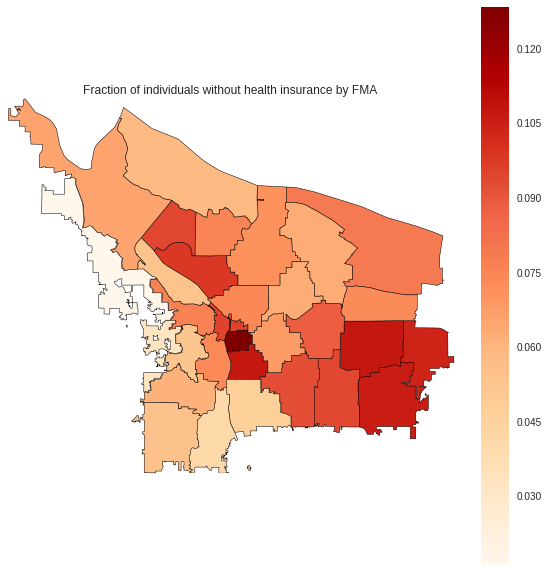

In [63]:
gplt.choropleth(df5,
                hue=df6['percent_no_health_insurance'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of individuals without health insurance by FMA")

In [66]:
# explore educational attainment by FMA
# aggregate by calculating % of individuals with just college degree, % with college degree or higher

QUERY6= '''SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.bachelor_degree*f.overlap_cbg)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_college_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC
'''



In [67]:
df6 = gpd_query(QUERY6)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.bachelor_degree*f.overlap_cbg)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_college_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC


created geopandas dataframe!


In [68]:
df6[df6.columns[0:6]] 

,fma,total,college_grad,percent_college_grad,college_grad_or_higher,percent_college_grad_or_higher
0,27,3807.0,1477.0,0.388002,2856.913706,0.750341
1,15,7032.0,2399.0,0.341100,5110.201464,0.726724
2,16,2995.0,1024.0,0.341891,2147.014002,0.716751
3,03,19089.0,7699.0,0.403344,13611.320333,0.713053
4,10,7798.0,2936.0,0.376440,5442.791215,0.697954
5,05,12927.0,4404.0,0.340710,8671.975085,0.670859
6,04,12800.0,4517.0,0.352925,8396.738025,0.655990
7,09,26581.0,9890.0,0.372060,17082.269334,0.642642
8,13,19132.0,6785.0,0.354660,12075.981566,0.631189
9,06,1398.0,450.0,0.322149,844.389567,0.603891


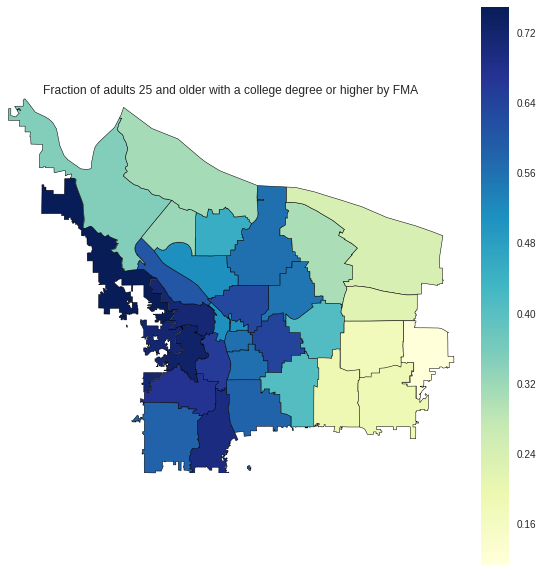

In [69]:
gplt.choropleth(df6,
                hue=df6['percent_college_grad_or_higher'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlGnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of adults 25 and older with a college degree or higher by FMA")

In [70]:
# explore food stamps by FMA
QUERY7 = '''SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_cbg)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_cbg)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC
'''


In [71]:
df7 = gpd_query(QUERY7)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_cbg)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_cbg)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC


created geopandas dataframe!


In [72]:
df7[df7.columns[:5]]

,fma,total,rec_food_stamps,percent_rec_fs,dn_red_food_stamps
0,07,14879.0,5227.0,0.351334,9651.0
1,11,12245.0,4077.0,0.332946,8168.0
2,31,10189.0,3620.0,0.355314,6569.0
3,25,17263.0,3421.0,0.198168,13842.0
4,19,12574.0,2596.0,0.206478,9978.0
5,14,14326.0,2370.0,0.165424,11957.0
6,03,14052.0,2219.0,0.157923,11833.0
7,29,7960.0,2149.0,0.269995,5811.0
8,04,10015.0,1865.0,0.186252,8150.0
9,09,15456.0,1832.0,0.118504,13625.0


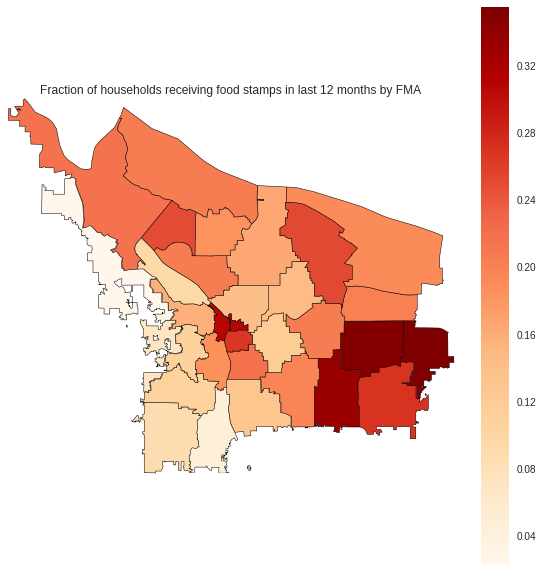

In [73]:
gplt.choropleth(df7,
                hue=df7['percent_rec_fs'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households receiving food stamps in last 12 months by FMA")

In [83]:
# explore household language by FMA
# I chose to aggregate by housholds that speak English only
# we also migh try to look at number of limited english speaking households

QUERY8='''SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.english_only*f.overlap_cbg)) AS english_only,
  ((sum(c.english_only*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_english_only,
  (round((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))) AS total_lesh,
  (((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))/
  (sum(c.estimate_total*f.overlap_cbg))) AS percent_total_lesh,
  s.geom    
FROM fmac_proportion f INNER JOIN census_household_language c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_total_lesh DESC
'''



In [84]:
df8 = gpd_query(QUERY8)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.english_only*f.overlap_cbg)) AS english_only,
  ((sum(c.english_only*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_english_only,
  (round((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))) AS total_lesh,
  (((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))/
  (sum(c.estimate_total*f.overlap_cbg))) AS percent_total_lesh,
  s.geom    
FROM fmac_proportion f INNER JOIN census_household_language c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_total_lesh DESC


created geopandas dataframe!


In [85]:
df8[df8.columns[:6]]

,fma,total,english_only,percent_english_only,total_lesh,percent_total_lesh
0,07,14879.0,10056.0,0.675863,1797.0,0.120807
1,31,10189.0,6841.0,0.671418,1127.0,0.110622
2,11,12245.0,8277.0,0.675937,1303.0,0.106402
3,29,7960.0,5512.0,0.692388,722.0,0.090656
4,02,5894.0,4366.0,0.740741,469.0,0.079562
5,12,6274.0,4806.0,0.766100,381.0,0.060692
6,04,10015.0,7775.0,0.776391,570.0,0.056941
7,30,8969.0,7189.0,0.801552,495.0,0.055228
8,19,12574.0,10495.0,0.834642,603.0,0.047934
9,26,7094.0,5487.0,0.773484,283.0,0.039835


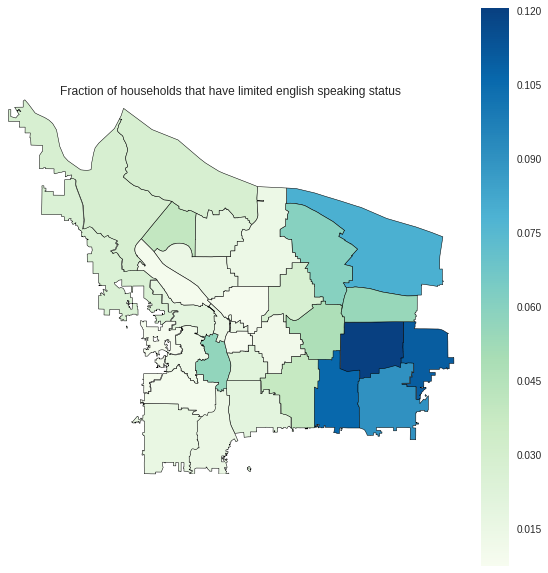

In [87]:
gplt.choropleth(df8,
                hue=df8['percent_total_lesh'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='GnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that have limited english speaking status")

In [ ]:
# explore race by FMA


In [ ]:
# try joining census_household_income by census block group to fma to look at income distribution

QUERY5='''SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_124999,
  round(sum(c.total_125000_to_149999*f.overlap_fma)) AS fr_125000_to_149999,
  round(sum(c.total_150000_to_199999*f.overlap_fma)) AS fr_150000_to_199999,
  round(sum(c.total_200000_or_more*f.overlap_fma)) AS fr_200000_or_more
FROM fmac_proportion f INNER JOIN census_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY f.fma
'''

In [ ]:
df5 = pquery(QUERY5)

In [ ]:
df5.info()

In [ ]:
df5

In [ ]:
for i in df5['fma']:
    df5.loc[df5['fma'] == i,'less_than_10000':].plot(kind = 'bar',title = "fma#= "+str(i))
    # Shrink current axis by 20%
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            